In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
plt.ion()
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
from mesa import Agent, Model
from mesa.time import RandomActivation
import random

%matplotlib inline
# The below is needed for both notebooks and scripts

import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
import pandas as pd
from mpmath import polylog
import sys
from networkx.utils import powerlaw_sequence
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from mesa.time import BaseScheduler
pd.options.display.max_rows = None
from sklearn.metrics import mean_squared_error

# Let's play with Agent-Based Now 

## Agents: 

In [2]:
class RandomActivation(BaseScheduler):
    """ A scheduler which activates each agent once per step, in random order,
    with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask agents...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step(model) method.

    """

    def step(self, social = False) -> None:
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        self.social = social 
        for agent in self.agent_buffer(shuffled=True):
            agent.step(social)
 
        self.steps += 1
        self.time += 1
        
        
        
class State(enum.IntEnum):
    """
    ODE equation for SEIURRDD: 
    S1 = S0 - S0.(ε_i.I_u0+ε_u.I_r0)
    E1 = S0.(ε_i.I_u0+ε_u.I_r0) - γE0
    I_r1= αγE0 -(μ_i+θ_i)I_r0
    I_u1 = (1-α)γE0 -(μ_u+θ_u)I_u0
    R_r1 = θ_i.I_r0
    R_u1 = θ_u.I_u0
    D_r1 = μ_i.I_r0
    D_u1 = μ_u.I_r0
    """
    SUSCEPTIBLE = 0
    EXPOSED = 1
    REPORTED_INFECTED = 2
    UNREPORTED_INFECTED = 3 
    REPORTED_RECOVERED= 4
    UNREPORTED_RECOVERED = 5
    REPORTED_DEATH = 6
    UNREPORTED_DEATH = 7
    IMPORTED=8
    QUARANTINED=9

class CovidAgent(Agent):
    """This is a class of agents living inside the territory of Australia, each of them have been affected by imported agents"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.state = State.SUSCEPTIBLE 
        self.day = 0 
        
    def step(self,social=False):
        """Take a step forwards in time in 2 condition""" 
        self.contact()
        self.status(social)

    def get_val(self):
        return 0 
    
    def status(self, social = False):
        """Check infection status 1 if loop for exposed condition and 1 for infected condition"""
        #social distancing policy
        """
        EXPOSED
        """
        if self.state == State.EXPOSED: 
            """
            beta: the reporting rate, transferring population of U->I, the way to  determine this value
            is to fit with the real datase. Then use probability distribution to earn the value
            """
            if self.day > self.model.T1: #T_1 - Latency Period
                if self.random.random()<self.model.beta: #Beta
                    self.state = State.REPORTED_INFECTED
                    self.day = self.get_val()
                else:
                    self.state = State.UNREPORTED_INFECTED # (1-beta)
                    self.day = self.get_val()

            else:
                self.day+=1

        elif self.state == State.REPORTED_INFECTED:   #Reported

            if self.random.random()>self.model.muy:  #Muy
                if self.day>self.model.TR: #T_R
                    self.state = State.REPORTED_RECOVERED
                else:
                    self.day+=1
            else: #1-Muy
                if self.day> self.model.TD: #T_D
                    self.state=State.REPORTED_DEATH
                else:
                    self.day+=1
        elif self.state == State.UNREPORTED_INFECTED: 
            if self.day >self.model.T+self.model.T2: # T: incubation period, T2: reporting period
                if self.random.random()<alpha: #alpha
                    self.state= State.REPORTED_INFECTED
    
                else: #1-alpha
                    if self.random.random()>self.model.muy:  #Muy
                        if self.day>self.model.TR: #T_R
                            self.state = State.UNREPORTED_RECOVERED
                        else:
                            self.day+=1
                    else: #1-Muy
                        if self.day> self.model.TD: #T_D
                            self.state=State.UNREPORTED_DEATH
                        else:
                            self.day+=1
            else:
                self.day+=1
        elif self.state == State.IMPORTED:
            
            if self.random.random()<self.model.epsilon:
                self.state = State.UNREPORTED_INFECTED 
                self.day = self.get_val()
        

   
    def contact(self):
        """Find close contacts and infect"""

        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)

        susceptible_neighbors = random.choices(neighbors,k = self.model.getcontact())
        #susceptible_population = [i for i in susceptile_neighbors if i.state == State.SUSCEPTIBLE]
        for other in susceptible_neighbors: 
            if self.state is State.REPORTED_INFECTED and other.state is State.SUSCEPTIBLE:  
                if self.random.random() <self.model.p: #this is transmissibility 
                    other.state = State.EXPOSED
                    other.day=0

            elif self.state is State.UNREPORTED_INFECTED and other.state is State.SUSCEPTIBLE:  
                if self.random.random() <self.model.p: #
                    other.state = State.EXPOSED
                    other.day=0

## Model 

In [38]:
class NetworkInfectionModel(Model):
    """
    parameters: 
    + Beta: asymtomatic probability
    + Theta: Recovery probability
    + Mu: Death probability
    + alpha: reporting rate
    + N: population 
    + pr: transmissibility
    + y: gamma - latency rate
    + T: Recovery/Death period
    """

    def __init__(self, N=1000,agent=500,p=0.63, beta =0.092,alpha=0.9,muy=0.05, T1=2,T2=4,TR=11,TD=20,T=5,TQ=14
                , epsilon=0.01, omega=0.01,contact=4,contact_sd=1):
        """
        All parameters
        """
        self.num_nodes = N  
        self.agent=agent
        self.alpha = alpha
        self.beta = beta
        self.T1=T1
        self.T2=T2
        self.T=T
        self.TR=TR
        self.TD=TD
        self.TQ=TQ
        self.p=p
        self.epsilon=epsilon
        self.omega=omega
        self.muy = muy #deathrate
        self.contact=contact
        self.contact_sd=contact_sd

        #create network here: 
        self.G = nx.complete_graph(self.num_nodes, create_using=nx.Graph())

        #self.G=nx.configuration_model(n)
        self.G.remove_edges_from(list(nx.selfloop_edges(self.G)))
        self.grid = NetworkGrid(self.G)

        self.schedule = RandomActivation(self) #activate the step of Agents in random orders
        self.running = True
      
        for i, node in enumerate(self.G.nodes()):
            a = CovidAgent(i+1, self)
            a.state = State.SUSCEPTIBLE
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            infected = np.random.choice([0,1], p=[(self.num_nodes-10)/self.num_nodes,10/self.num_nodes])
            if infected == 1:
                a.state = State.UNREPORTED_INFECTED
                a.day=0

        
        
        #add agent
        #self.create_agents()
      
        self.datacollector = DataCollector(            
            agent_reporters={"State": 'state'})

        
    def create_agents(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            a = CovidAgent(self.rn, self)
            self.schedule.add(a)
            a.state=State.INFECTED
            self.grid.place_agent(a, self.rn)
            a.status()
            a.contact()
            # Create intra-agents
            self.m.remove(self.rn)
    def create_agents_second(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            b = CovidAgent(self.rn, self)
            self.schedule.add(b)
            b.state=State.QUARANTINED
            self.grid.place_agent(b, self.rn)
            b.status()
            
            self.m.remove(self.rn)
    def getcontact(self):
        return int(np.random.lognormal(self.contact,self.contact_sd,1))


    def step(self,new=0,second_phase=False, social = False):
        #Câu chuyện ở đây là ông cần phải có grid thì mới có agent để add vô, nếu chỉ có add_nodes thì nó quá đơn thuần và không có agent
        self.datacollector.collect(self)
        self.schedule.step(social)

        

## Run model 

# Simulation 
    

In [36]:
import scipy

from scipy.stats import lognorm
# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")
def fit_contact(C):
    bo=[]
    for i in C:
        bo.append(math.log(i/min(C)+1))
    a = 1+(len(C)/sum(bo))
    return a
def predict_contact(C):
    prob = []
    for i in C:
        prob.append(((a-1)/(np.min(C)+1))*(i/((np.min(C)+1))**-a))         
    return prob
def simulation(modelinput):
    b=0.092 #asymtomatic rate 
    p=0.63 #transmissibility 
    a=0.9 #reporting rate
    day=1
    T_r=2
    T_u=3 
    rrate=0.7/T_r
    rdeath=0.03/T_r  
    U = 4
    I = 0 
    UIE = np.random.randint(0,30,size=99)
    UIE = np.insert(UIE,0,U)
    IIE = I+np.random.randint(0,30,size=99)
    IIE=np.insert(IIE,0,0)
    UD=UIE*rdeath
    UR=(UIE-UD)*rrate
    II=IIE+ (UIE-UD-UR)*a
    UI=UIE-(UIE-UD-UR)*a-UR-UD
    ID=II*rdeath/T_r
    IR=(II-ID)*rrate/T_r
    df = pd.DataFrame({'unreported_infection':UI,'unreported_death':UD,'unreported_rec':UR,'infect':II,'death':ID,'rec':IR})
    C=[]
  
    for i in range(len(UD)-1):
        c=(UI[i+1]+II[i+1])/((UI[i]+II[i])*p+1)

        C.append(c)
    C.append(1)
    C=np.array(C)
    C.astype('int')
    bo=[]
    for i in C:
        bo.append(math.log(i/min(C)+1))
    g = 1+(len(C)/sum(bo))
    #prob = predict_contact()
    df['contact']=C
    #df['prob']=prob
    CI=[]
    CU=[]
    for x,y,z in zip(df['unreported_infection'],df['infect'],df['contact']):
        try:
            ci=z/((x/y)+1)
            CI.append(ci)
        except ZeroDivisionError:
            ci=0
            CI.append(ci)
    df['contact_I']=CI
    CU=C-CI
    df['contact_U']=CU
    data=1000-modelinput
    cc=np.random.lognormal(1,1,18)
    bb=cc*(UI[:18]+II[:18])
    bb=bb.cumsum()
    MSE = mean_squared_error(bb, data[:18])
    RMSE = math.sqrt(MSE)

    
    # Set list of distributions to test
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more

    dist_names = ['beta',
                  'halfcauchy',
                  'expon',
                  'gamma',
                  'lognorm',
                  'norm',
                  'pearson3',
                  'triang',
                  'uniform',
                  'weibull_min', 
                  'weibull_max',
                  'pareto', 'powerlaw',]

    # Set up empty lists to stroe results
    chi_square = []
    p_values = []

    # Set up 50 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    percentile_bins = np.linspace(0,100,len(C))
    percentile_cutoffs = np.percentile(C, percentile_bins)
    observed_frequency, bins = (np.histogram(C, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(C)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(C, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * 100
        cum_expected_frequency = np.cumsum(expected_frequency)
        if cum_expected_frequency[0]==0: 
            ss=0
            chi_square.append(ss)
        else:
            ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
            chi_square.append(ss)

    # Collate results and sort by goodness of fit (best at top)
    """
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    """
    

    # Report results


    return dist_names,chi_square,p_values,RMSE

In [37]:
import pandas as pd
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Reported_Infected','Unreported_Infected','Reported_Recovered','Unreported_Recovered','Reported_death','Unreported_death']
    X.columns = labels[:len(X.columns)]
    return X
#print(d3.sort_values(['chi_square'], inplace=True)
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return X

df3=pd.DataFrame()
df2=pd.DataFrame() #p_value
df1=pd.DataFrame() #chisquare
RMSEs=[]

steps=35
st=time.time()
model = NetworkInfectionModel(N=1000)
for i in range(steps):
    model.step()
get_column_data(model)


AttributeError: 'NetworkInfectionModel' object has no attribute 'contact'

<AxesSubplot:title={'center':'Goodness of distribution fit with Chi-square'}, xlabel='iteration'>

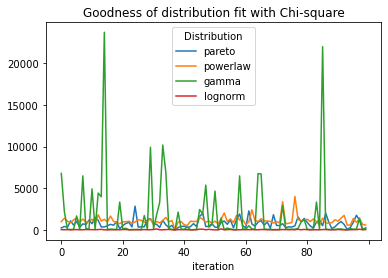

In [6]:
for i in range(100):
    name,chi,p_value,rmse=simulation(get_column_data(model)['Susceptible'][:18])
    df1['Distribution'] = name
    df1[str(i)]= chi
    df2['Distribution'] = name
    df2[str(i)]=p_value
    RMSEs.append(rmse)
df1.set_index('Distribution',inplace = True)

horizontal =np.linspace(1,100,100)
compare=df1.T[['pareto','powerlaw','gamma','lognorm']]
compare.plot(title='Goodness of distribution fit with Chi-square',xlabel='iteration',xticks=None)

<AxesSubplot:title={'center':'Goodness of distribution fit with p-value'}, xlabel='iteration'>

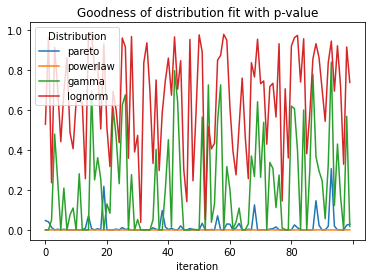

In [7]:
df2.set_index('Distribution',inplace = True)
horizontal =np.linspace(1,100,100)
comparep=df2.T[['pareto','powerlaw','gamma','lognorm']]
comparep.plot(title='Goodness of distribution fit with p-value',xlabel='iteration',xticks=None)

In [8]:
df3['Distribution']=name
df3['chi_square']= df1.sum(axis=1).values/100
df3['p_value']=df2.sum(axis=1).values/100
print ('\nDistributions sorted by goodness of fit:')
print ('The lower the chi-squared value the better the fit.')
print ('----------------------------------------')
df3.sort_values(['chi_square'], inplace=True)


Distributions sorted by goodness of fit:
The lower the chi-squared value the better the fit.
----------------------------------------


In [9]:
df3

,Distribution,chi_square,p_value
4,lognorm,30.798443,6.600265e-01
6,pearson3,81.444062,3.058492e-01
9,weibull_min,163.968928,2.390728e-01
0,beta,235.887434,2.884307e-01
1,halfcauchy,353.584792,3.369360e-02
2,expon,368.801191,8.697230e-02
11,pareto,745.703742,1.585270e-02
5,norm,1003.789929,2.038700e-03
12,powerlaw,1117.553922,1.500000e-06
7,triang,1453.326684,2.000000e-07


In [10]:
R=np.array(RMSEs)

In [11]:
r=R/10

NameError: name 'az' is not defined

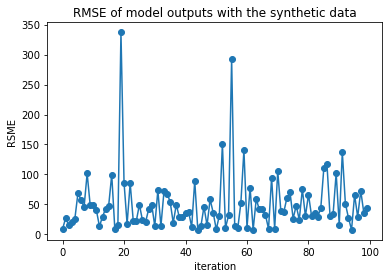

In [12]:
plt.title('RMSE of model outputs with the synthetic data')
plt.xlabel('iteration')
plt.ylabel('RSME')
plt.plot(r,marker='o',label='RMSE')
plt.plot(horizontal,az,label='mean')
plt.legend()
plt.grid(1)

In [13]:
np.std(r)

49.368033282881896

In [14]:
az=[]
az.append(np.mean(r))

In [15]:
az=az*100

In [16]:
nm['RMSE']=r

NameError: name 'nm' is not defined

In [17]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [18]:
mean_confidence_interval(r, confidence=0.95)

(50.37295589639993, 40.527918175381714, 60.217993617418145)

In [19]:
agent_state = model.datacollector.get_agent_vars_dataframe()

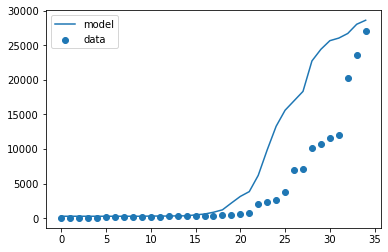

In [71]:
x = np.linspace(0,34,35)
plt.scatter(x,np.sort(d),label='data')
plt.plot(x,np.sort(get_column_data(model)['Susceptible']),label='model')
plt.legend()

In [69]:
np.sort(get_column_data(model)['Susceptible'])

array([  9,   9,   9,   9,   9,   9,   9,   9,   9,   9,  10,  10,  10,
        11,  11,  16,  20,  29,  41,  75, 108, 132, 213, 340, 458, 538,
       585, 632, 784, 842, 885, 898, 921, 967, 987])

In [25]:
class O:
    import random
    def __init__(self):
        self.day=0
    
    def con(self,a,b):
        m=self.random.random()
        if m<a:
            print(m)
            self.day=self.val()
        else: 
            self.day+=1
        d=self.random.random()
        if d<b:
            print(d)
        else:
            self.day+=1
    def val(self):
        return 0

In [26]:
a = O()

In [33]:
a.con(4,4)

0.13565124831560627
0.5972226065107455


In [34]:
a.day

0